In [148]:
import numpy as np
import mega
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes
cm = plt.cm.get_cmap('plasma_r')
v_lim = [5, 8]

In [8]:
hip = np.genfromtxt('hipparcos-bright-result.csv', delimiter=',',skip_header=1,usecols=[1])

In [22]:
sims = mega.get_simulations()

In [201]:
def generate_fig(filename=None, latitude=50., months=[-3,0,3], hours=[-3,0,3]): 
    # latitude in degrees
    # months since spring equinox
    # hours since midnight
    fig, axs = plt.subplots(len(hours),2*len(months),figsize=(21,10), constrained_layout=True, squeeze=False)
    for i, hour in enumerate(hours):
        for j, month in enumerate(months):
            xy, mag = mega.get_stereographic_data(sims, latitude=latitude, month=month, hour=hour)

            ax = axs[i][2*j] 
            ax.set_aspect("equal")
            r_lim = 1.02
            ax.set_xlim(-r_lim,r_lim)
            ax.set_ylim(-r_lim,r_lim)

            # hide axes
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            for s in ax.spines:
                ax.spines[s].set_visible(False)

            # setup labels    
            r_labels = 1.07    
            for k, d in enumerate(["N","W","S","E"]):
                ax.text(r_labels*np.sin(k*np.pi/2.),r_labels*np.cos(k*np.pi/2.), d, ha="center", va="center")
            ax.text(0.65,-0.95,"N=%d"%len(xy)) 

            # background
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=-10, color="black"))
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=3, edgecolor="k", facecolor="none", lw=3))

            # plot
            im=ax.scatter(xy[:,0],xy[:,1],s=4, c=mag, cmap=cm,vmin=v_lim[0],vmax=v_lim[1])
            
            ax = axs[i][2*j+1] 
            ax.set_facecolor("black")

            ax.set_xlabel("Vmag")
            ax.set_yscale("log")
            ax.set_ylim([0.4,1000])
            magbins = np.linspace(-1,8,50)
            ax.set_xlim([magbins.min(),magbins.max()])
            
            ax.hist(hip,bins=magbins,histtype="step",color="w",weights=np.ones(len(hip))*0.5);
            ax.plot([1e-4],[1e-4],color="w",label="Stars") # dummy
            n, bins, patches = ax.hist(mag,bins=magbins)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])

            handles, labels = ax.get_legend_handles_labels()
            # scale values to interval [0,1]
            col = bin_centers - v_lim[0]
            col /= (v_lim[1] - v_lim[0])
            handle = Rectangle((0, 0), 1, 1)
            handles.append(handle)
            handler_map = {handle: HandlerColormap(cm, num_stripes=256)}
            for c, p in zip(col, patches):
                plt.setp(p, 'facecolor', cm(c))
            
            leg = ax.legend(framealpha=0.2,handles=handles,labels=labels+["Artificial\nsatellites"],handler_map=handler_map, loc="upper left",handlelength=5)
            for text in leg.get_texts():
                text.set_color("w")
            

    cb = fig.colorbar(im,ax=axs,label="Vmag",shrink=1./len(hours))
    if filename is not None:
        plt.savefig(filename,facecolor='white', transparent=False,dpi=200)
        plt.close(fig)
    

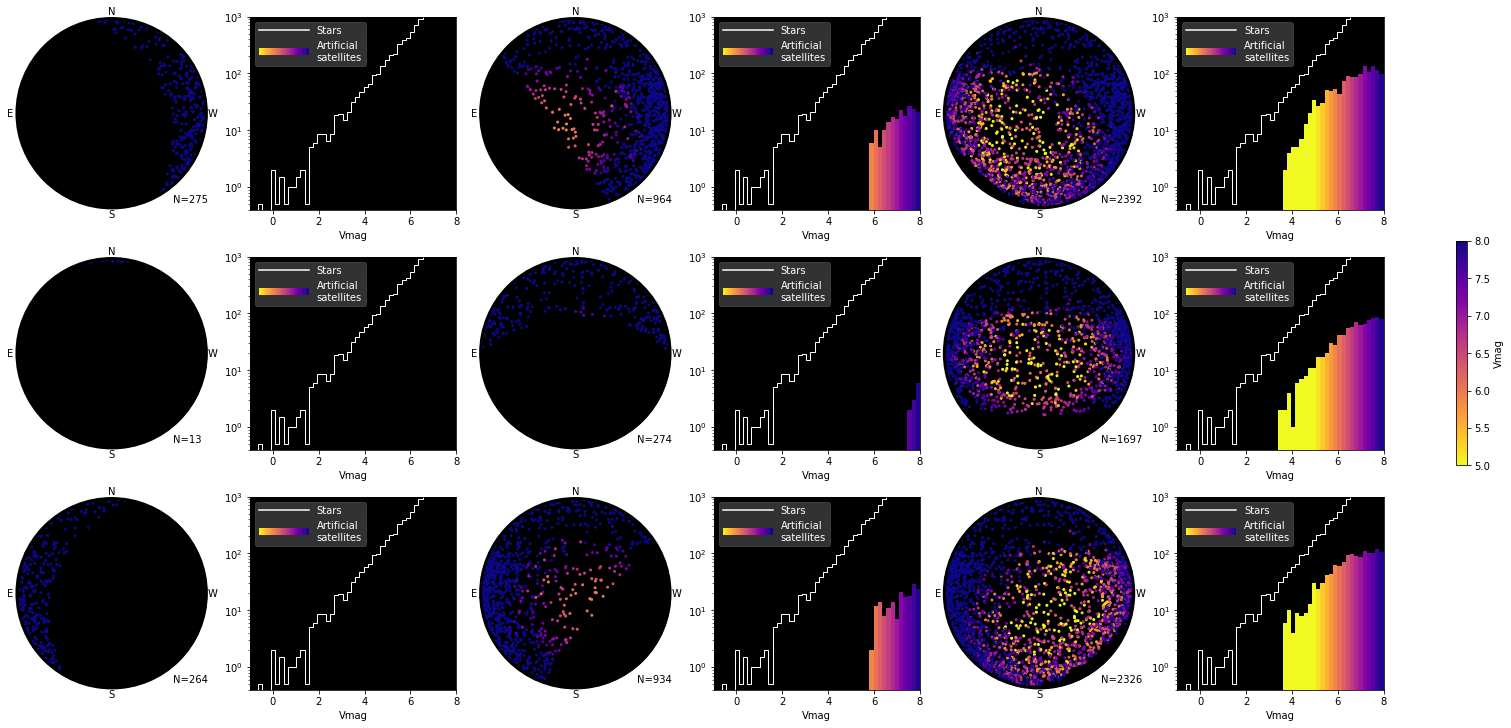

In [202]:
generate_fig(latitude=50.)

In [203]:
generate_fig("PH_hawaii.pdf", latitude=20)
generate_fig("PH_eq.pdf", latitude=0)
generate_fig("PH_north.pdf", latitude=90)
generate_fig("PH_canada.pdf", latitude=50)

In [204]:
!open .